In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
import numpy as np

Afficher les GPU disponibles

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

Device utilisé : cuda


Charger les images

In [8]:
train_dir = '../images/train'
test_dir = '../images/test'

Transformations pour prÃ©traitement des images

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalisation entre -1 et 1
])

Chargement des datasets

In [10]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Création du modèle

In [12]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Passe à vide pour calculer la taille d'entrée pour la couche dense
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            output_size = self.features(dummy_input).view(-1).shape[0]
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(output_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


Instancier le modèle et l'envoyer sur le device (GPU/CPU)

In [13]:
model = CNNModel().to(device)

Définition de la fonction de perte et de l'optimiseur

In [14]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

Entrainement du modèle

In [27]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=15):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

In [28]:
train_model(model, train_loader, criterion, optimizer, device)

Epoch [1/15], Loss: 0.2080
Epoch [2/15], Loss: 0.1542
Epoch [3/15], Loss: 0.1212
Epoch [4/15], Loss: 0.1177
Epoch [5/15], Loss: 0.0782
Epoch [6/15], Loss: 0.1422
Epoch [7/15], Loss: 0.0628
Epoch [8/15], Loss: 0.0509
Epoch [9/15], Loss: 0.0424
Epoch [10/15], Loss: 0.0536
Epoch [11/15], Loss: 0.0297
Epoch [12/15], Loss: 0.0096
Epoch [13/15], Loss: 0.0068
Epoch [14/15], Loss: 0.0035
Epoch [15/15], Loss: 0.0025


Evaluation du modèle

In [32]:
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            preds = (outputs > 0.5).cpu().numpy().astype(int)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
    return y_true, y_pred

In [33]:
y_true, y_pred = evaluate_model(model, test_loader, device)

Calcul de l'accuracy

In [34]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.8455


Afficher des prédictions sur des images aléatoires

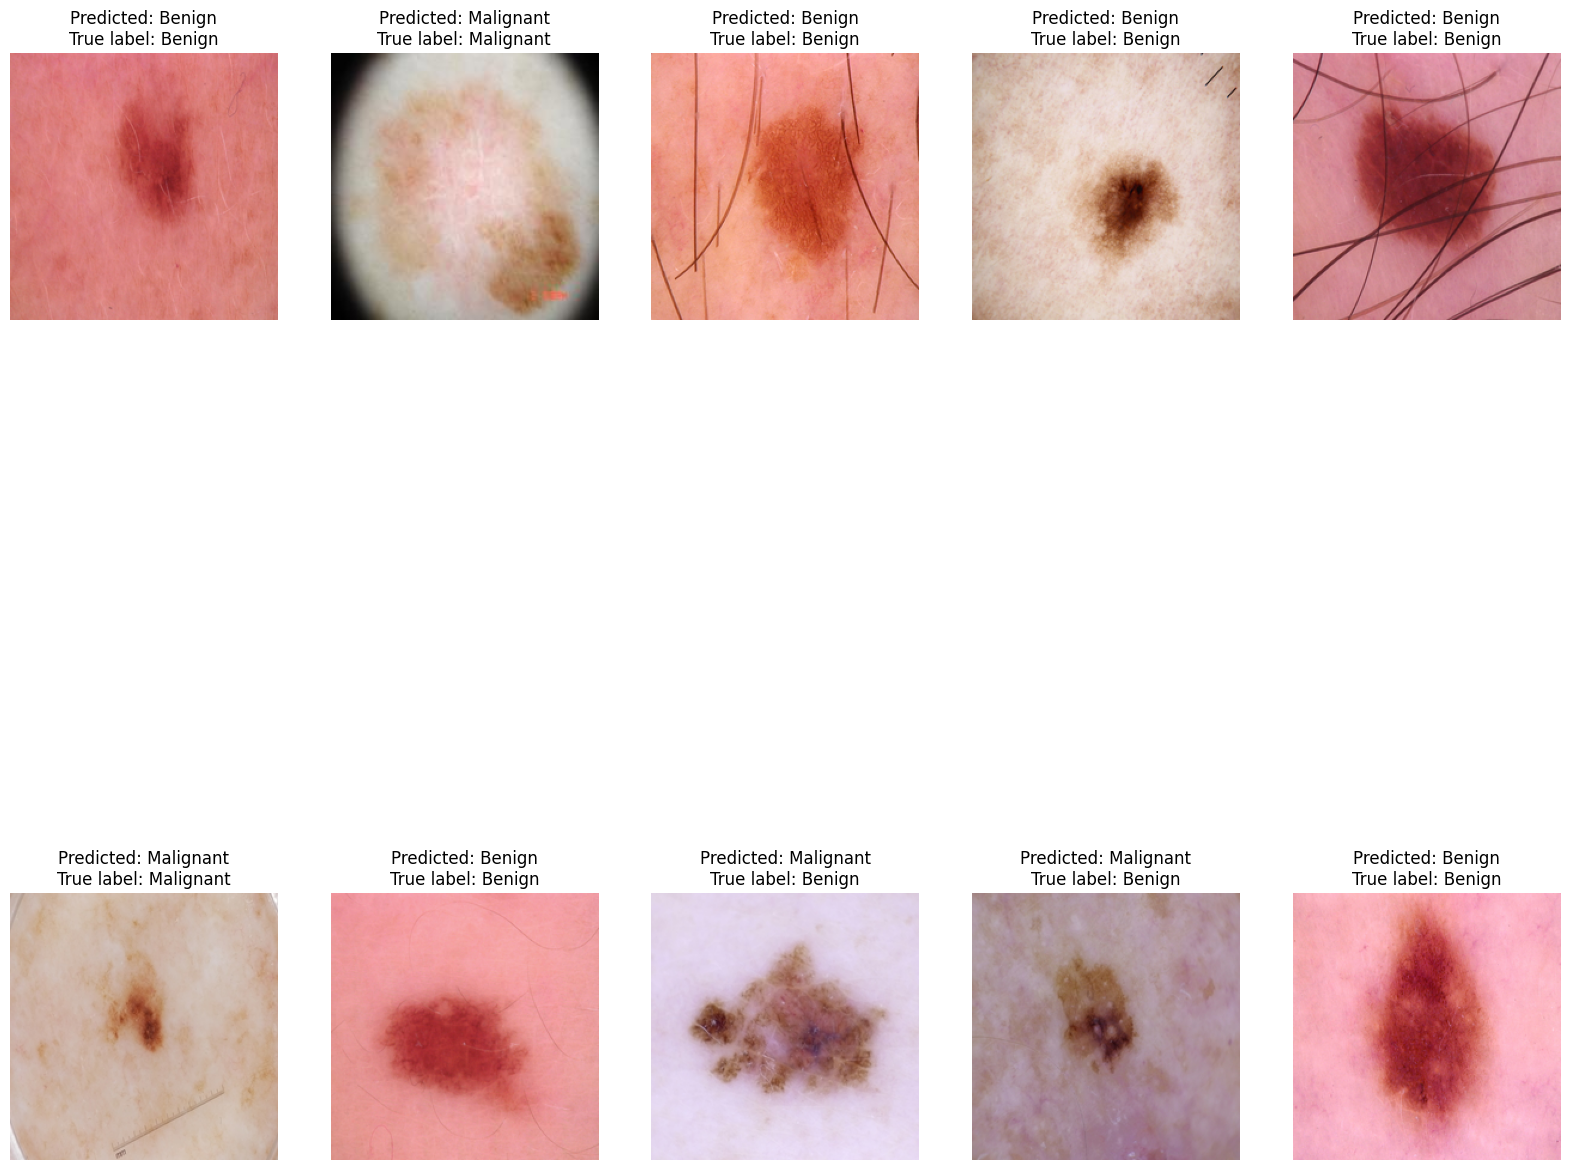

In [35]:
def show_predictions(model, test_loader, device):
    model.eval()
    random_indices = random.sample(range(len(test_dataset)), 10)
    fig, axes = plt.subplots(2, 5, figsize=(20, 20))
    for i, idx in enumerate(random_indices):
        image, label = test_dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor).item()
            prediction = 'Malignant' if output > 0.5 else 'Benign'
            truelabel = 'Malignant' if label == 1 else 'Benign'
        ax = axes[i // 5, i % 5]
        ax.imshow(np.transpose((image.numpy() * 0.5 + 0.5), (1, 2, 0)))  # Rescale pour affichage
        ax.set_title(f"Predicted: {prediction}\nTrue label: {truelabel}")
        ax.axis('off')
show_predictions(model, test_loader, device)

Sauvegarder le modèle

In [22]:
torch.save(model.state_dict(), '../saved_models/pytorch_cnn_skincancer.pth')